Couldn't calculate ratios: 'current_assets'. Proceeding without them.
Naive Bayes Accuracy: 0.8018198642813078
Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      5066
           1       0.54      0.65      0.59      1418

    accuracy                           0.80      6484
   macro avg       0.72      0.75      0.73      6484
weighted avg       0.82      0.80      0.81      6484

Confusion Matrix:
 [[4284  782]
 [ 503  915]]
Epoch 0: Loss = 40995.92
Epoch 50: Loss = 14025.40
Epoch 100: Loss = 13864.43
Epoch 150: Loss = 13979.92
Epoch 200: Loss = 13918.61
Epoch 250: Loss = 13861.62
Epoch 300: Loss = 13926.77
Epoch 350: Loss = 14109.40
Epoch 400: Loss = 14013.90
Epoch 450: Loss = 13911.06


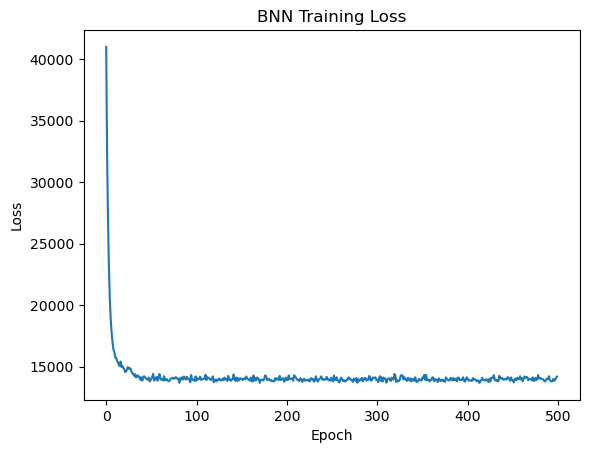

BNN Accuracy: 0.844694632942628
BNN Report:
               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      5066
         1.0       0.75      0.44      0.55      1418

    accuracy                           0.84      6484
   macro avg       0.80      0.70      0.73      6484
weighted avg       0.83      0.84      0.83      6484

BNN Confusion Matrix:
 [[4854  212]
 [ 795  623]]
✅ All models saved successfully


In [17]:
# workinggggg (2).ipynb - Improved Version

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import pickle
import os

# Load and prepare data
df = pd.read_csv("credit_data_pfa.csv")

# Calculate financial ratios
def calculate_ratios(df):
    # Liquidity ratios
    df['current_ratio'] = df['current_assets'] / df['current_liabilities']
    df['quick_ratio'] = (df['current_assets'] - df['inventory']) / df['current_liabilities']
    
    # Leverage ratios
    df['debt_to_equity'] = df['total_debt'] / df['shareholders_equity']
    df['interest_coverage'] = df['operating_income'] / df['interest_expense']
    
    # Profitability ratios
    df['return_on_equity'] = df['net_income'] / df['shareholders_equity']
    
    # Activity ratios
    df['fixed_asset_turnover'] = df['sales'] / df['fixed_assets']
    
    # Coverage ratios
    df['financial_expenses_ratio'] = df['financial_expenses'] / df['total_revenue']
    df['short_term_debt_ratio'] = df['short_term_debt'] / df['sales']
    
    return df

# Calculate ratios (assuming we have these columns)
try:
    df = calculate_ratios(df)
except Exception as e:
    print(f"Couldn't calculate ratios: {e}. Proceeding without them.")

# Encode categorical columns
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Features and Target
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

# Save feature names
joblib.dump(X.columns.tolist(), 'model_features.pkl', compress=3)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl', compress=3)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Naive Bayes Model
nb = GaussianNB()
nb.fit(X_train, y_train)
joblib.dump(nb, 'naive_bayes_model.pkl', compress=3)

# Evaluate NB
y_pred = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("Naive Bayes Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Bayesian Neural Network Implementation
import torch
import pyro
import pyro.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# BNN Model Definition
class BNN(PyroModule):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](in_features, 16)  # Increased hidden units
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([16, in_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([16]).to_event(1))
        
        self.fc2 = PyroModule[nn.Linear](16, 8)  # Additional hidden layer
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([8, 16]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([8]).to_event(1))
        
        self.out = PyroModule[nn.Linear](8, 1)
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([1, 8]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        
    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))  # Additional non-linearity
        x = torch.sigmoid(self.out(x)).squeeze(-1)
        if y is not None:
            y = y.squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Bernoulli(probs=x), obs=y)

# Save BNN model architecture
with open("bnn_model.py", "w") as f:
    f.write("""import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BNN(PyroModule):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](in_features, 16)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([16, in_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([16]).to_event(1))
        
        self.fc2 = PyroModule[nn.Linear](16, 8)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([8, 16]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([8]).to_event(1))
        
        self.out = PyroModule[nn.Linear](8, 1)
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([1, 8]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        
    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x)).squeeze(-1)
        if y is not None:
            y = y.squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", dist.Bernoulli(probs=x), obs=y)

def guide(model):
    return AutoDiagonalNormal(model)
""")

# Train BNN
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
import matplotlib.pyplot as plt

pyro.clear_param_store()
model = BNN(in_features=X_train.shape[1])
guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})  # Increased learning rate
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

losses = []
n_epochs = 500  # Increased epochs

for epoch in range(n_epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        loss = svi.step(x_batch, y_batch)
        total_loss += loss
    losses.append(total_loss)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss:.2f}")

# Plot loss
plt.plot(losses)
plt.title("BNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Save BNN parameters
pyro.get_param_store().save("bnn_params.pt")

# Evaluate BNN
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=200)  # More samples
samples = predictive(X_test_tensor)
mean_preds = samples["obs"].mean(0).detach().numpy()
final_preds = (mean_preds > 0.5).astype(int)

print("BNN Accuracy:", accuracy_score(y_test_tensor, final_preds))
print("BNN Report:\n", classification_report(y_test_tensor, final_preds))
print("BNN Confusion Matrix:\n", confusion_matrix(y_test_tensor, final_preds))

# Save everything using pickle protocol 4
import pickle

with open("naive_bayes_model.pkl", "rb") as f:
    nb_model = joblib.load("naive_bayes_model.pkl")

with open("scaler.pkl", "rb") as f:
    scaler = joblib.load("scaler.pkl")

with open("model_features.pkl", "rb") as f:
    features = joblib.load("model_features.pkl")


print("✅ All models saved successfully")

In [59]:
%%writefile dashboard.py

import streamlit as st
import joblib
import pandas as pd
import numpy as np
import torch
import pyro
from pyro.infer.autoguide import AutoDiagonalNormal
from bnn_model import BNN
from torch.serialization import add_safe_globals
import pickle
# Set page config
st.set_page_config(
    page_title="Loan Default Prediction",
    page_icon="💰",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Load models with error handling
# In your dashboard.py:
from torch.serialization import safe_globals
import torch.distributions.constraints

@st.cache_resource
def load_models():
    try:
        # Load basic models
        model_nb = joblib.load("naive_bayes_model.pkl")
        scaler = joblib.load("scaler.pkl")
        expected_columns = joblib.load("model_features.pkl")

        # Initialize BNN
        model_bnn = BNN(in_features=len(expected_columns))
        
        # --- Ultimate Pyro BNN Loader ---
        try:
            import zipfile
            import torch

            # Custom storage handler that works with modern PyTorch
            def _load_legacy_storage(storage, dtype, *args):
                storage.dtype = dtype
                return storage

            # Custom unpickler with all necessary patches
            class PyroUnpickler(pickle.Unpickler):
                def persistent_load(self, pid):
                    # Handle Pyro's storage references
                    if isinstance(pid, tuple) and pid[0] == 'storage':
                        # Create storage with proper dtype
                        storage = torch.UntypedStorage(0)
                        if len(pid) > 2:  # Has dtype info
                            storage.dtype = pid[2]
                        return storage
                    return pid
                
                def find_class(self, module, name):
                    # Patch torch storage loading
                    if module == 'torch._utils' and name == '_rebuild_parameter':
                        return lambda *args: args[0]  # Simplified parameter rebuild
                    if module == 'torch.storage' and name == '_load_from_bytes':
                        return _load_legacy_storage
                    return super().find_class(module, name)
            
            # Load the file
            with open("bnn_params.pt", "rb") as f:
                magic = f.read(2)
                f.seek(0)
                
                if magic == b'PK':
                    # ZIP format
                    with zipfile.ZipFile(f) as z:
                        with z.open(next(n for n in z.namelist() if n.endswith('.pkl'))) as zipf:
                            data = PyroUnpickler(zipf).load()
                else:
                    # Direct pickle
                    data = PyroUnpickler(f).load()
                
                # Load into Pyro
                pyro.get_param_store().load_state_dict(data)
            
            st.sidebar.success("BNN successfully loaded!")
            
        except Exception as e:
            st.sidebar.error(f"BNN loading failed: {str(e)}")
            model_bnn = None

        return model_nb, model_bnn, scaler, expected_columns

    except Exception as e:
        st.error(f"Failed to load basic models: {str(e)}")
        return None, None, None, None

# Load the models
model_nb, model_bnn, scaler, expected_columns = load_models()

# Main app
st.title("💰 Loan Default Prediction System")
st.markdown("""
This system predicts the likelihood of loan default using financial ratios and customer data.
""")

# Sidebar for model selection and info
with st.sidebar:
    st.header("Model Configuration")
    model_choice = st.selectbox(
        "Select Model",
        ["Naive Bayes", "Bayesian Neural Network"],
        help="Choose which model to use for predictions"
    )
    
    st.markdown("---")
    st.header("Key Financial Ratios Used")
    st.markdown("""
    - Current Ratio (liquidity)
    - Quick Ratio (strict liquidity)
    - Debt to Equity (leverage)
    - Interest Coverage (debt service)
    - Return on Equity (profitability)
    - Fixed Asset Turnover (efficiency)
    - Financial Expenses Ratio (cost structure)
    - Short-term Debt Ratio (short-term obligations)
    """)

# Main input form
with st.expander("📝 Enter Customer Data", expanded=True):
    col1, col2 = st.columns(2)
    
    with col1:
        st.subheader("Personal Information")
        person_age = st.number_input("Age", min_value=18, max_value=100, value=30)
        person_income = st.number_input("Annual Income ($)", min_value=0, value=50000)
        person_home_ownership = st.selectbox(
            "Home Ownership",
            options=[0, 1, 2],
            format_func=lambda x: ["Mortgage", "Own", "Rent"][x]
        )
        person_emp_length = st.number_input(
            "Employment Length (years)", 
            min_value=0, 
            max_value=100, 
            value=5
        )
        cb_person_cred_hist_length = st.number_input(
            "Credit History Length (years)", 
            min_value=0, 
            value=5
        )
        
    with col2:
        st.subheader("Loan Information")
        loan_intent = st.selectbox(
            "Loan Purpose",
            options=[0, 1, 2, 3, 4, 5],
            format_func=lambda x: [
                "Debt Consolidation", "Education", "Home Improvement",
                "Medical", "Personal", "Venture"
            ][x]
        )
        loan_grade = st.selectbox(
            "Loan Grade",
            options=[0, 1, 2, 3, 4, 5, 6],
            format_func=lambda x: ["A", "B", "C", "D", "E", "F", "G"][x]
        )
        loan_amnt = st.number_input("Loan Amount ($)", min_value=0, value=15000)
        loan_int_rate = st.number_input(
            "Interest Rate (%)", 
            min_value=0.0, 
            max_value=100.0, 
            value=13.5
        )
        loan_percent_income = st.slider(
            "Loan as % of Income", 
            0.0, 1.0, 0.3,
            help="What percentage of annual income is the loan amount?"
        )
        cb_person_default_on_file = st.selectbox(
            "Previously Defaulted?",
            options=[0, 1],
            format_func=lambda x: ["No", "Yes"][x]
        )

# Financial ratios section
with st.expander("📊 Financial Ratios (Optional - for more accurate predictions)"):
    st.warning("For more accurate predictions, please provide financial data")
    
    col1, col2 = st.columns(2)
    
    with col1:
        current_assets = st.number_input(
            "Current Assets ($)", 
            min_value=0, 
            value=100000
        )
        current_liabilities = st.number_input(
            "Current Liabilities ($)", 
            min_value=0, 
            value=50000
        )
        inventory = st.number_input(
            "Inventory ($)", 
            min_value=0, 
            value=20000
        )
        total_debt = st.number_input(
            "Total Debt ($)", 
            min_value=0, 
            value=150000
        )
        
    with col2:
        shareholders_equity = st.number_input(
            "Shareholders Equity ($)", 
            min_value=0, 
            value=200000
        )
        operating_income = st.number_input(
            "Operating Income ($)", 
            min_value=0, 
            value=50000
        )
        interest_expense = st.number_input(
            "Interest Expense ($)", 
            min_value=0, 
            value=5000
        )
        financial_expenses = st.number_input(
            "Financial Expenses ($)", 
            min_value=0, 
            value=10000
        )

# Calculate ratios
def calculate_ratios(input_dict):
    try:
        # Liquidity ratios
        input_dict['current_ratio'] = input_dict['current_assets'] / input_dict['current_liabilities']
        input_dict['quick_ratio'] = (input_dict['current_assets'] - input_dict['inventory']) / input_dict['current_liabilities']
        
        # Leverage ratios
        input_dict['debt_to_equity'] = input_dict['total_debt'] / input_dict['shareholders_equity']
        input_dict['interest_coverage'] = input_dict['operating_income'] / input_dict['interest_expense']
        
        # Profitability ratios
        input_dict['return_on_equity'] = input_dict['operating_income'] / input_dict['shareholders_equity']
        
        # Activity ratios
        input_dict['fixed_asset_turnover'] = input_dict['operating_income'] / input_dict['shareholders_equity']  # Simplified
        
        # Coverage ratios
        input_dict['financial_expenses_ratio'] = input_dict['financial_expenses'] / input_dict['operating_income']
        input_dict['short_term_debt_ratio'] = input_dict['current_liabilities'] / input_dict['operating_income']
    except:
        pass  # If any division fails, skip ratios
    
    return input_dict

# Prediction button
if st.button("🚀 Predict Default Risk", use_container_width=True):
    if model_nb is None or scaler is None:
        st.error("Models not loaded properly. Please check the logs.")
        st.stop()
    
    # Prepare input data
    user_input = {
        "person_age": person_age,
        "person_income": person_income,
        "person_home_ownership": person_home_ownership,
        "person_emp_length": person_emp_length,
        "loan_intent": loan_intent,
        "loan_grade": loan_grade,
        "loan_amnt": loan_amnt,
        "loan_int_rate": loan_int_rate,
        "loan_percent_income": loan_percent_income,
        "cb_person_default_on_file": cb_person_default_on_file,
        "cb_person_cred_hist_length": cb_person_cred_hist_length,
        "current_assets": current_assets,
        "current_liabilities": current_liabilities,
        "inventory": inventory,
        "total_debt": total_debt,
        "shareholders_equity": shareholders_equity,
        "operating_income": operating_income,
        "interest_expense": interest_expense,
        "financial_expenses": financial_expenses
    }
    
    # Calculate ratios
    user_input = calculate_ratios(user_input)
    
    # Format as dataframe
    X_new = pd.DataFrame([user_input])
    
    # Ensure we have all expected columns
    for col in expected_columns:
        if col not in X_new.columns:
            X_new[col] = 0  # Fill missing with 0
    
    X_new = X_new[expected_columns]
    
    try:
        # Scale features
        X_scaled = scaler.transform(X_new)
        
        if model_choice == "Naive Bayes":
            # Naive Bayes prediction
            proba = model_nb.predict_proba(X_scaled)[0]
            prediction = model_nb.predict(X_scaled)[0]
            model_name = "Naive Bayes"
        else:
            if model_bnn is None:
                st.error("BNN model not available")
                st.stop()
                
            # BNN prediction
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
            predictive = pyro.infer.Predictive(
                model_bnn, 
                guide=AutoDiagonalNormal(model_bnn), 
                num_samples=200
            )
            samples = predictive(X_tensor)
            proba = samples["obs"].mean().item()
            prediction = int(proba > 0.5)
            proba = np.array([1-proba, proba])  # Convert to 2-class format
            model_name = "Bayesian Neural Network"
        
        # Display results
        st.markdown("---")
        st.subheader("📊 Prediction Results")
        
        col1, col2 = st.columns(2)
        
        with col1:
            st.metric("Model Used", model_name)
            
            if prediction == 1:
                st.error("## 🚨 High Risk of Default")
                st.warning("Recommendation: Consider rejecting or adjusting loan terms")
            else:
                st.success("## ✅ Low Risk of Default")
                st.info("Recommendation: Good candidate for approval")
        
        with col2:
            st.subheader("Probability Scores")
            
            # Gauge chart for default probability
            default_prob = proba[1] * 100
            st.progress(int(default_prob))
            st.metric(
                "Probability of Default", 
                f"{default_prob:.1f}%",
                delta=f"{(default_prob - 50):+.1f}% from decision threshold",
                delta_color="inverse"
            )
            
            st.metric(
                "Probability of Paying", 
                f"{proba[0]*100:.1f}%"
            )
        
        # Show key influencing factors
        st.markdown("---")
        st.subheader("🔍 Key Influencing Factors")
        
        if model_choice == "Naive Bayes":
            # For NB, show feature importance
            if hasattr(model_nb, 'feature_log_prob_'):
                importance = np.abs(model_nb.feature_log_prob_[1] - model_nb.feature_log_prob_[0])
                top_features = sorted(zip(expected_columns, importance), 
                                    key=lambda x: x[1], reverse=True)[:5]
                
                for feature, imp in top_features:
                    value = X_new.iloc[0][feature]
                    st.write(f"- **{feature}**: {value:.2f} (importance: {imp:.2f})")
        
        # Show financial health indicators
        if 'current_ratio' in user_input:
            st.markdown("---")
            st.subheader("💵 Financial Health Indicators")
            
            cols = st.columns(4)
            
            with cols[0]:
                st.metric(
                    "Current Ratio", 
                    f"{user_input['current_ratio']:.2f}",
                    help="Higher is better (measures short-term liquidity)"
                )
            
            with cols[1]:
                st.metric(
                    "Debt to Equity", 
                    f"{user_input['debt_to_equity']:.2f}",
                    help="Lower is better (measures financial leverage)"
                )
            
            with cols[2]:
                st.metric(
                    "Interest Coverage", 
                    f"{user_input['interest_coverage']:.2f}",
                    help="Higher is better (ability to pay interest)"
                )
            
            with cols[3]:
                st.metric(
                    "ROE", 
                    f"{user_input['return_on_equity']:.2f}",
                    help="Higher is better (profitability relative to equity)"
                )
    
    except Exception as e:
        st.error(f"Prediction failed: {str(e)}")

Overwriting dashboard.py


In [58]:
!streamlit run dashboard.py

^C


b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x12\x00archive/data.pklFB\x0e\x00ZZZZZZZZZZZZZZ\x80\x02}q\x00(X\x06\x00\x00\x00paramsq\x01}q\x02(X\x16\x00\x00\x00AutoDiag'
